# Recommendation System Based on Product Descriptions

In this notebook, we'll explore a content-based recommendation system that clusters products based on their descriptions. Such an approach is particularly useful for businesses without prior user-item interaction data.

## 1. Introduction

Recommendation systems aim to suggest items to users based on various factors. Traditional systems often rely on historical user-item interactions. However, for new e-commerce platforms or businesses, there's a lack of user purchase history. In such cases, we can design recommendation systems based on the content, such as product descriptions. This method clusters similar items together, allowing us to recommend products from the same cluster to users.


## 2. Textual Clustering

Textual clustering is the foundation of our recommendation system. We'll group products based on the similarity of their descriptions. Products within the same cluster are considered related and can be recommended interchangeably.

### Advantages of Textual Clustering:
- **Cold Start Problem**: Useful for new platforms without user interaction data.
- **Content Richness**: Product descriptions offer rich insights into product features, making them suitable for content-based recommendations.


## 3. Feature Extraction - TF-IDF Vectorization

To process and cluster text data, we need to convert it into a numerical format. Here, we'll use the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization technique.

### Understanding TF-IDF:
- **Term Frequency (TF)**: Frequency of a word in a document.
- **Inverse Document Frequency (IDF)**: Inverse of the frequency of the word across all documents. Words common across documents (like "and", "the") have lower IDF values.
- **TF-IDF**: Product of TF and IDF, giving high importance to words that are frequent in a document but not across all documents.


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
df = pd.read_csv('Amazon_Sales_Data.csv')

# Using a subset for demonstration
df_subset = df.head(500)

# Extract features from product descriptions using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_subset["about_product"])


## 4. K-Means Clustering

With the product descriptions vectorized, we'll use the K-Means clustering algorithm to group similar products.

### How K-Means Works:
1. **Initialization**: Choose the number of clusters (K) and initialize centroids.
2. **Assignment**: Assign each item to the nearest centroid.
3. **Update**: Compute the mean of all items assigned to each centroid and reset this mean as the new centroid.
4. **Convergence**: Repeat the assignment and update steps until the centroids don't change significantly.

Choosing the right number of clusters (K) is crucial. Here, we've selected K=10 for demonstration, but in practice, techniques like the elbow method can be used to find an optimal K.


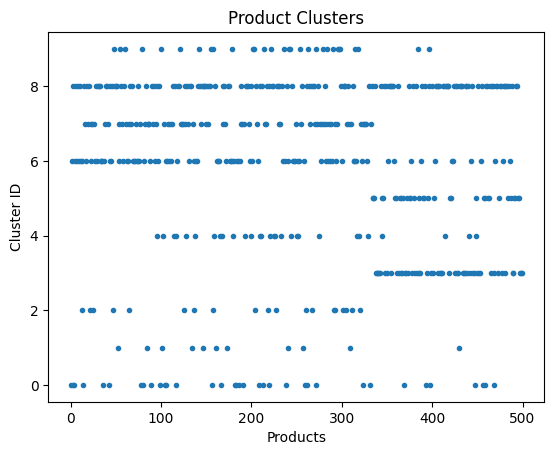

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Applying K-Means clustering
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
y_kmeans = kmeans.fit_predict(X)

# Visualize the product clusters
plt.plot(y_kmeans, ".")
plt.title("Product Clusters")
plt.xlabel("Products")
plt.ylabel("Cluster ID")
plt.show()


## 5. Making Recommendations

Our recommendation logic is straightforward:
1. For a given product, determine its cluster.
2. Recommend other products from the same cluster.

Let's define functions to display the characteristic terms of each cluster and to recommend products based on a given product description.


In [5]:
# Function to display top terms per cluster
def print_cluster(i, order_centroids, terms):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(terms[ind], end=", ")
    print("\n")

# Displaying top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(10):
    print_cluster(i, order_centroids, terms)

# Assigning clusters to the dataframe
df_subset['cluster_id'] = y_kmeans

# Updated Recommendation function
def show_recommendations(product):
    Y = vectorizer.transform([product])
    prediction = kmeans.predict(Y)
    cluster_products = df_subset[df_subset['cluster_id'] == prediction[0]].head(5)
    
    print(f"Recommended products for:\n{product}\n")
    for _, row in cluster_products.iterrows():
        print(f"Product ID: {row['product_id']}")
        print(f"Price: {row['discounted_price']}")
        print(f"Image URL: {row['img_link']}")
        print(f"Description: {row['about_product']}\n")
        print('-'*60)

Cluster 0:
iphone, ipad, pro, plus, 12, charging, mini, 13, max, cable, 

Cluster 1:
added, g7, protection, usb, improve, s10, durability, g6, g8, fraying, 

Cluster 2:
hdmi, cable, male, audio, 4k, xbox, ethernet, video, supports, tv, 

Cluster 3:
camera, sim, 2mp, f2, battery, display, dual, 5g, core, processor, 

Cluster 4:
remote, keypad, order, quality, match, image, placing, bn59, tv, led, 

Cluster 5:
watch, smartwatch, sports, health, modes, faces, boltt, calling, display, day, 

Cluster 6:
usb, cable, type, charging, data, charge, speed, micro, devices, fast, 

Cluster 7:
product, connect, ports, tv, installation, warranty, information, features, sound, usb, 

Cluster 8:
cable, charging, usb, free, fast, design, type, data, power, devices, 

Cluster 9:
remote, tv, stick, control, led, amazon, gen, compatible, batteries, mi, 



C:\Users\wasim\AppData\Local\Temp\ipykernel_35044\3087571147.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cluster_id'] = y_kmeans
C:\Users\wasim\AppData\Local\Temp\ipykernel_35044\3087571147.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cluster_id'] = y_kmeans


In [6]:
# You can replace the argument with any product description from your dataset
show_recommendations("hdmi cable for 4K video streaming")

Recommended products for:
hdmi cable for 4K video streaming

Product ID: B07KSMBL2H
Price: ₹219
Image URL: https://m.media-amazon.com/images/I/41nPYaWA+ML._SY300_SX300_.jpg
Description: Flexible, lightweight HDMI cable for connecting media devices to playback display such as HDTVs, projectors, and more|Compatible with Blu-Ray players, computers, Apple TV, Roku, cable, PS4, Xbox One, and other HDMI-compatible devices|Solid copper conductors and full metal jacket shielding for durability and high-performance connectivity|Supports Ethernet, 3D, 4K video and Audio Return Channel (ARC) and meets the latest HDMI standards|Supports bandwidth up to 18Gbps and is backwards compatible with earlier versions|Includes a 3 foot cable

------------------------------------------------------------
Product ID: B085194JFL
Price: ₹279
Image URL: https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/31MIyzg8uzL._SX300_SY300_QL70_FMwebp_.jpg
Description: Superior Stability: Built-in advanced Certified

## 6. Conclusion

We've implemented a content-based recommendation system
